# XLMRat PCAP Malware Analysis Notebook

## 📥 Step 1: Load the PCAP File
First, we'll use **Scapy** to load and parse the PCAP file, which contains network packets captured during a potential malware infection.

In [3]:
# Import necessary Scapy components
from scapy.all import rdpcap, TCP, Raw, IP

# Load the PCAP file
packets = rdpcap('236-XLMRat.pcap')
print(f"Total packets loaded: {len(packets)}")

Total packets loaded: 1550


## 🌐 Step 2: Extract HTTP Requests
We filter packets for HTTP GET or POST requests to identify URLs accessed by the infected machine. This helps pinpoint where the malware was downloaded from.

In [4]:
# Extract and reconstruct HTTP requests from TCP payloads
http_requests = []
for pkt in packets:
    if pkt.haslayer(TCP) and pkt.haslayer(Raw):
        try:
            payload = pkt[Raw].load.decode('utf-8', errors='ignore')
            if 'GET' in payload or 'POST' in payload:
                lines = payload.splitlines()
                method = lines[0] if lines else ''
                host = next((line.split(':', 1)[1].strip() for line in lines if line.lower().startswith('host:')), '')
                uri = method.split(' ')[1] if ' ' in method else ''
                full_url = f"http://{host}{uri}"
                http_requests.append(full_url)
        except Exception:
            continue

print("🔗 URLs extracted from the PCAP:")
for url in http_requests:
    print(url)

🔗 URLs extracted from the PCAP:
http://45.126.209.4:222/xlm.txt
http://45.126.209.4:222/mdm.jpg


## 🛰️ Step 3: Determine Hosting Provider
Now we take the host from the malicious URL and determine the IP address and hosting provider using `socket` and `requests`.

In [5]:
import socket
import requests
from urllib.parse import urlparse

# Parse the IP address from the first suspicious URL
target_url = http_requests[0]
host = urlparse(target_url).hostname
ip = socket.gethostbyname(host)

# Query ipinfo.io to get hosting provider
resp = requests.get(f"https://ipinfo.io/{ip}/org")
print(f"IP Address: {ip}")
print(f"Hosting Provider: {resp.text.strip()}")

IP Address: 45.126.209.4
Hosting Provider: AS23470 ReliableSite.Net LLC


Question1: 1.	By analyzing the malicious scripts, two payloads were identified: a loader and a secondary executable. What is the SHA256 of the malware executable? (hint: SHA256 ends with "d798")



Solution
1- in Wireshark
   - open 236-XLMRat.pcap
   - then file > Export Objects > HTTP; save the 2 files revealed
   - since the malware is in the mdm.jpg, follow the TCP stream from the source IP 10.1.9.101 that sent a GET with that file on HTTP: tcp.stream eq 1
   - then save the payload into payload.txt
2- in Linux
   - upload the payload.txt
   - then applt command $ cat payload.txt | tr -d '_' | xxd -r -p > payload.bin
   - follow by command $ sha256sum payload.bin
   - Result: 1eb7b02e18f67420f42b1d94e74f3b6289d92672a0fb1786c30c03d68e81d798


Question2: What is the malware family label based on Alibaba?

Solution:
1- Create an account on virustotal and export an API KEY
2- In Linux, Run the API request: $curl -X GET "https://www.virustotal.com/api/v3/files/1eb7b02e18f67420f42b1d94e74f3b6289d92672a0fb1786c30c03d68e81d798" \
     -H "x-apikey: 2cb3e22ee2187d0e42d9798c0ca2e1ad20ce2dab3a11e464799ec8ae0fe5d690"
3- In Linux, install jq: $ sudo apt install jq
4- then rerun: $ curl -s -X GET "https://www.virustotal.com/api/v3/files/1eb7b02e18f67420f42b1d94e74f3b6289d92672a0fb1786c30c03d68e81d798" \
  -H "x-apikey: 2cb3e22ee2187d0e42d9798c0ca2e1ad20ce2dab3a11e464799ec8ae0fe5d690" \
  | jq -r '.data.attributes.last_analysis_results.Alibaba.result'

5- Result: Backdoor:MSIL/AsyncRat.a2786761

The malware family label based on Alibaba is AsyncRat

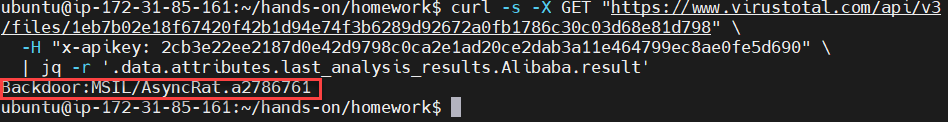


Question3: What is the timestamp of the malware's creation? (hint: YYYY-MM-DD hh:mm)

Solution
1- In Linux, run $ curl -s -X GET "https://www.virustotal.com/api/v3/files/1eb7b02e18f67420f42b1d94e74f3b6289d92672a0fb1786c30c03d68e81d798"   -H "x-apikey: 2cb3e22ee2187d0e42d9798c0ca2e1ad20ce2dab3a11e464799ec8ae0fe5d690"   | jq -r '.data.attributes.creation_date'   | xargs -I{} date -d @{} "+%Y-%m-%d %H:%M"

2- Result: 2023-10-30 15:08

Explanation

"jq -r '.data.attributes.creation_date' pulls the UNIX timestamp from the JSON.

date -d @{} "+%Y-%m-%d %H:%M" converts it to human-readable format.




Question4: Which LOLBin is leveraged for stealthy process execution in this script? Provide the full path

Solution
1- in linux, run $tshark -r 236-XLMRat.pcap -qz follow,tcp,ascii,1 | grep "exe"
2- result: $AC = $NA + 'osof#####t.NET\Fra###mework\v4.0.303###19\R##egSvc#####s.exe'-replace  '#', ''
set "ps=powershell.exe"

3- Remove the #
$ tshark -r 236-XLMRat.pcap -qz follow,tcp,ascii,1 | tr -d '#' | grep "exe"

result: $AC = $NA + 'osoft.NET\Framework\v4.0.30319\RegSvcs.exe'-replace  '', ''
set "ps=powershell.exe"

final: C:\Windows\Microsoft.NET\Framework\v4.0.30319\RegSvcs.exe


Question5: The script is designed to drop several files. List the names of the files dropped by the script. 

Solution: 
step 1: Bash script extract_dropped_files.sh that automate the process of looping all the TCP streams, extracting each stream as ASCII content, searching dropped file names, listing them.

#!/bin/bash

PCAP_FILE="236-XLMRat.pcap"
TEMP_STREAM="temp_stream.txt"
FOUND_FILES="dropped_files.txt"

# Clear output file if it exists
> "$FOUND_FILES"

# Get total number of TCP streams
TOTAL_STREAMS=$(tshark -r "$PCAP_FILE" -T fields -e tcp.stream | sort -n | uniq | wc -l)

echo "[*] Total TCP streams found: $TOTAL_STREAMS"
echo "[*] Scanning streams for dropped files..."

# Loop through each stream number
for STREAM_NUM in $(seq 0 $((TOTAL_STREAMS - 1))); do
    # Extract stream content
    tshark -r "$PCAP_FILE" -qz follow,tcp,ascii,$STREAM_NUM > "$TEMP_STREAM"

    # Extract file-looking strings (e.g., .exe, .bat, .dll, etc.)
    grep -oEi '[a-zA-Z0-9_\-\\/:]+\.((exe)|(bat)|(dll)|(txt)|(dat)|(ps1)|(vbs)|(jpg)|(png)|(zip))' "$TEMP_STREAM" >> "$FOUND_FILES"
done

# Deduplicate results
sort -u "$FOUND_FILES" > "${FOUND_FILES}.unique"

echo "Done. Dropped files found:"
cat "${FOUND_FILES}.unique"

Step2: make the script executable: $chmod +x extract_dropped_files.sh

Step3: run the script: ./extract_dropped_files.sh

Step4: results
[*] Total TCP streams found: 4
[*] Scanning streams for dropped files...
Done. Dropped files found:
/mdm.jpg
/xlm.txt
C:\Users\Public\Conted.bat
C:\Users\Public\Conted.ps1
C:\Users\Public\Conted.vbs
Cmd.exe
POWeRSHeLL.eXe
nted.bat
powershell.exe
s.exe


Final: Conted.bat, Conted.ps1, Conted.vbs
